# Attempt to do UK coins feature extraction by Transfer Learning from Inception v3 model by Google

# Clear -ONLY FOR RESETTING ENVIRONMENT
Keras backend to try new model (Only do this if you want to change model parameters)

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Clear the current TensorFlow graph
K.clear_session(free_memory=True)


# Reinitialize your model from scratch
model = None  # Explicitly set to None
model = None
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

: 

In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

2025-04-03 17:36:25.382648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743698185.400643   45936 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743698185.406671   45936 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743698185.419287   45936 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743698185.419303   45936 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743698185.419305   45936 computation_placer.cc:177] computation placer alr

Download Weights

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2025-04-03 17:36:29--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.200.27, 216.58.212.219, 172.217.16.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.200.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

       /tmp/incepti   2%[                    ]   2.19M  3.54MB/s               ^C


# Import InceptionV3

In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

#local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5' # when running in Google Colab
local_weights_file = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5' # when running locally
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

I0000 00:00:1743698193.771523   45936 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9374 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


By specifying the include_top=False argument, we load a network that doesn't include the classification layers at the top—ideal for feature extraction.

Let's make the model non-trainable, since we will only use it for feature extraction; we won't update the weights of the pretrained model during training.

In [4]:
for layer in pre_trained_model.layers:
  layer.trainable = False

The layer we will use for feature extraction in Inception v3 is called `mixed7`. It is not the bottleneck of the network, but we are using it to keep a sufficiently large feature map (7x7 in this case). (Using the bottleneck layer would have resulting in a 3x3 feature map, which is a bit small.) Let's get the output from `mixed7`:

In [5]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output.shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


# Build the model
Now Let's stick a fully connected layer to that:

In [6]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers 
from keras.losses import CategoricalCrossentropy

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(256, activation='relu', #256
                 kernel_regularizer=regularizers.l2(0.001))(x)  # Added L2 regularization

# Dropout rate
x = layers.Dropout(0.8)(x)
# Final Relu function for non-binary classification
x = layers.Dense(8, activation='softmax')(x)

# Configure and compile
model = Model(pre_trained_model.input, x)
model.compile(loss=CategoricalCrossentropy(label_smoothing=0.1),   # 'categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['acc'])

Summary of the model:

In [7]:
# keeping output in a small scrollable window as model is huge 
from IPython.display import HTML

def get_model_summary(model):
    # Redirect model.summary() to a string
    import io
    summary_string = io.StringIO()
    model.summary(print_fn=lambda x: summary_string.write(x + '\n'))
    
    # Create scrollable container with monospace font for proper formatting
    return HTML(f'''
    <div style="max-height:300px; overflow:auto; font-family:monospace; white-space:pre;">
    {summary_string.getvalue()}
    </div>
    ''')

# Usage:
get_model_summary(model)

The model is designed and compiled

# Load our UK coins images

In [8]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# !wget https://edshare.gcu.ac.uk/id/document/61325 \
#       -O /content/UK_coins_ClassSplit.zip

# local_zip = './content/UK_coins_ClassSplit.rar'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('./')
# zip_ref.close()
UK_base_dir = './UK_coins_ClassSplit'

Take a look at coins to confirm fully loaded:

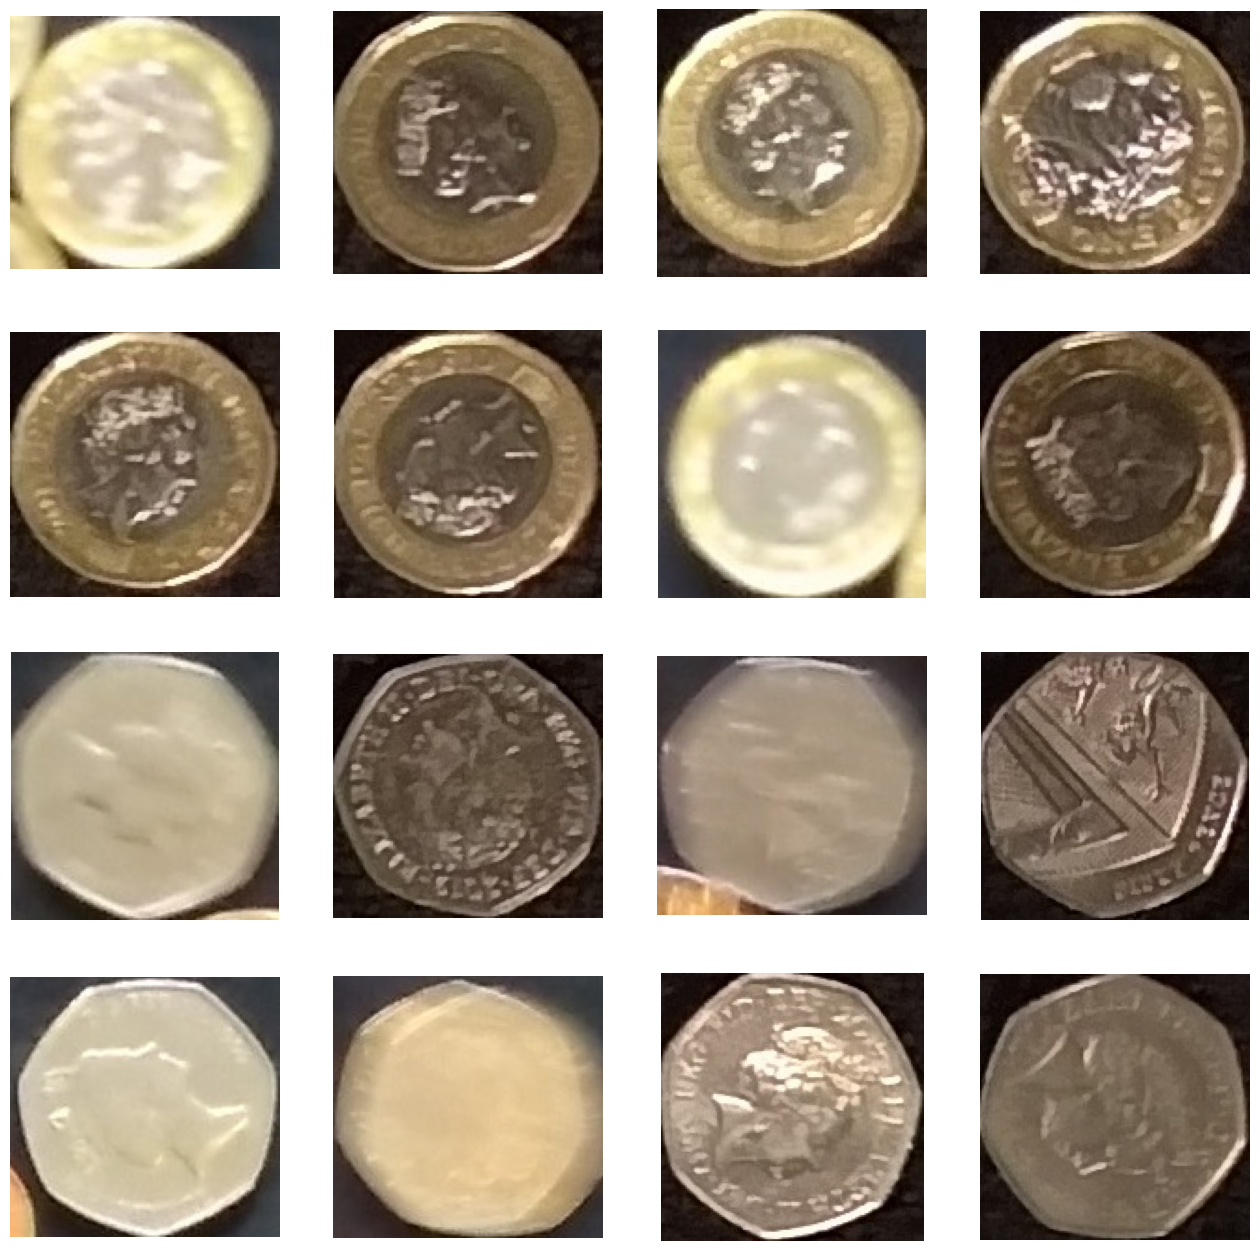

In [9]:
#@title Show some coins
UK_100_dir = os.path.join(UK_base_dir, '100')
UK_050_dir = os.path.join(UK_base_dir, '050')
nrows = 4
ncols = 4
train_100_fnames = os.listdir(UK_100_dir)
train_050_fnames = os.listdir(UK_050_dir)
pic_index = 0 # Index for iterating over images
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
pic_index += 8
next_100_pix = [os.path.join(UK_100_dir, fname)
                for fname in train_100_fnames[pic_index-8:pic_index]]
next_050_pix = [os.path.join(UK_050_dir, fname)
                for fname in train_050_fnames[pic_index-8:pic_index]]
for i, img_path in enumerate(next_100_pix+next_050_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

# Datagen
With the same Augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# All images will be rescaled by 1./255 and augmented
UK_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=360,        # This is good for coins
    width_shift_range=0.15,    
    height_shift_range=0.15,   
    zoom_range=0.15,           
    brightness_range=[0.7, 1.3], # Increase brightness variation
    shear_range=0.2,           # Add shear transformation
    channel_shift_range=0.2,   # Shift color channels slightly
    fill_mode='nearest',
    validation_split=0.2
)
B = 10 #Batch size
# Extract flow training images in batches of B images
UK_train_generator = UK_datagen.flow_from_directory(
        UK_base_dir,  # This is the source directory for training images
        target_size = (150, 150),  # All images will be resized to 150x150
        batch_size=B,
        subset = 'training',
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')
# Extract flow validation images in batches of B images
UK_validation_generator = UK_datagen.flow_from_directory(
        UK_base_dir,
        target_size=(150, 150),
        batch_size=B,
        subset = 'validation',
        class_mode='categorical')

Found 250 images belonging to 8 classes.


Found 59 images belonging to 8 classes.


# Train

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',  # or 'val_loss' depending on what you want to track
    patience=30,  # number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore to parameters providing best val_acc
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',       # Monitor validation accuracy
    factor=0.5,              # Reduce learning rate by half when triggered
    patience=5,              # Wait 5 epochs with no improvement before reducing
    min_delta=0.01,          # Minimum change to count as improvement
    min_lr=1e-9,             # Don't reduce learning rate below this value
    verbose=1                # Print message when reducing learning rate
)

history = model.fit(
      UK_train_generator,
      steps_per_epoch=250//B,  # 250 train images = batch_size * steps
      epochs=160,
      callbacks=[early_stopping, reduce_lr], # used for restoring best epoch parameters.
      validation_data=UK_validation_generator,
      validation_steps=59//B,  # 59 validation images = batch_size * steps
      verbose=2)

Epoch 1/160


/home/alex/MengTB/ImProMaV/cw2/.Keras/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1743698236.423919   46045 service.cc:152] XLA service 0x795b4c003f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743698236.423932   46045 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-04-03 17:37:16.547981: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743698237.665362   46045 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1743698240.737777  

25/25 - 12s - 494ms/step - acc: 0.1480 - loss: 3.0189 - val_acc: 0.1800 - val_loss: 2.5029 - learning_rate: 1.0000e-04
Epoch 2/160
25/25 - 1s - 54ms/step - acc: 0.1840 - loss: 2.6708 - val_acc: 0.3200 - val_loss: 2.3658 - learning_rate: 1.0000e-04
Epoch 3/160
25/25 - 1s - 58ms/step - acc: 0.2160 - loss: 2.5804 - val_acc: 0.3800 - val_loss: 2.3092 - learning_rate: 1.0000e-04
Epoch 4/160
25/25 - 1s - 55ms/step - acc: 0.3000 - loss: 2.4310 - val_acc: 0.4400 - val_loss: 2.2615 - learning_rate: 1.0000e-04
Epoch 5/160
25/25 - 1s - 53ms/step - acc: 0.2640 - loss: 2.4501 - val_acc: 0.4200 - val_loss: 2.2441 - learning_rate: 1.0000e-04
Epoch 6/160
25/25 - 1s - 54ms/step - acc: 0.2720 - loss: 2.3664 - val_acc: 0.4400 - val_loss: 2.1614 - learning_rate: 1.0000e-04
Epoch 7/160
25/25 - 1s - 55ms/step - acc: 0.3000 - loss: 2.3347 - val_acc: 0.4600 - val_loss: 2.1203 - learning_rate: 1.0000e-04
Epoch 8/160
25/25 - 1s - 56ms/step - acc: 0.2920 - loss: 2.2896 - val_acc: 0.3800 - val_loss: 2.1040 - lear

Plot results Accuracy

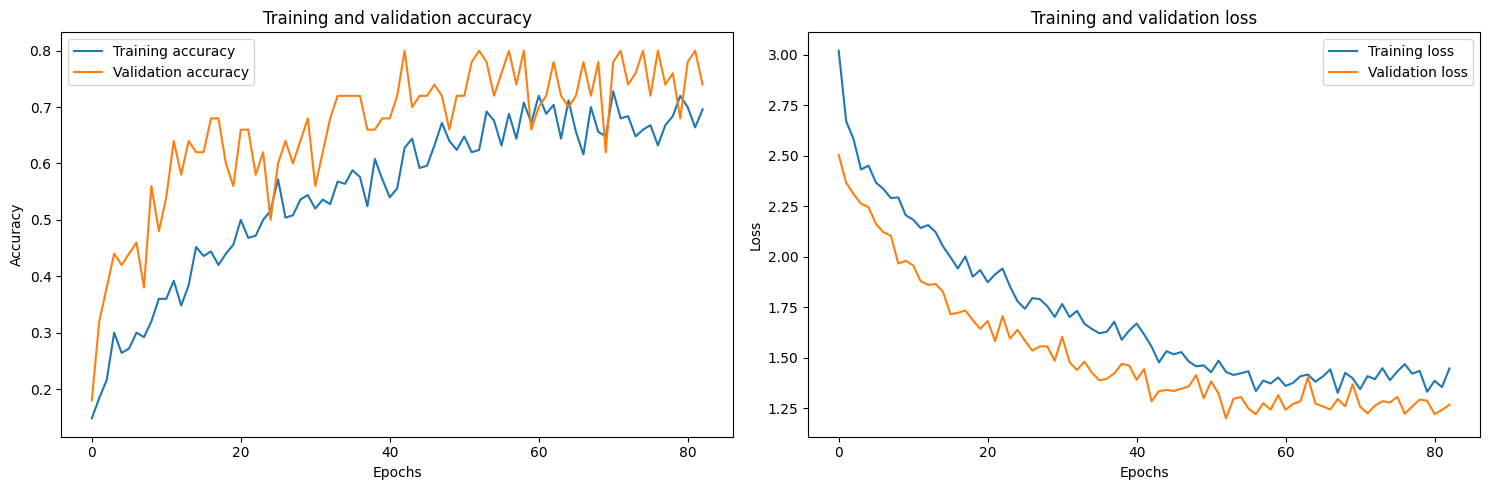

In [12]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']
# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
# Get number of epochs
epochs = range(len(acc))

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation accuracy on the first subplot
ax1.plot(epochs, acc, label='Training accuracy')
ax1.plot(epochs, val_acc, label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot training and validation loss on the second subplot
ax2.plot(epochs, loss, label='Training loss')
ax2.plot(epochs, val_loss, label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the figure
plt.show()

# Inference
That should be the classifier ready. If you wish, try to play inference on a new image using model.predict
https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict

In [13]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
#upload a new coin image and try to classify it
fname = "./manual_test/100.png" #update name as needed
img = load_img(fname, target_size=(150, 150))
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)
# Rescale by 1/255
x /= 255
# Let's run our image through our network
prediction = model.predict(x)
prediction
#class numbers corresponds to subdirectories (train_datagen.flow_from_directory uses alphabetic order by default)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


array([[0.00398816, 0.0079823 , 0.00306117, 0.00627861, 0.01890503,
        0.06980533, 0.05772099, 0.83225846]], dtype=float32)

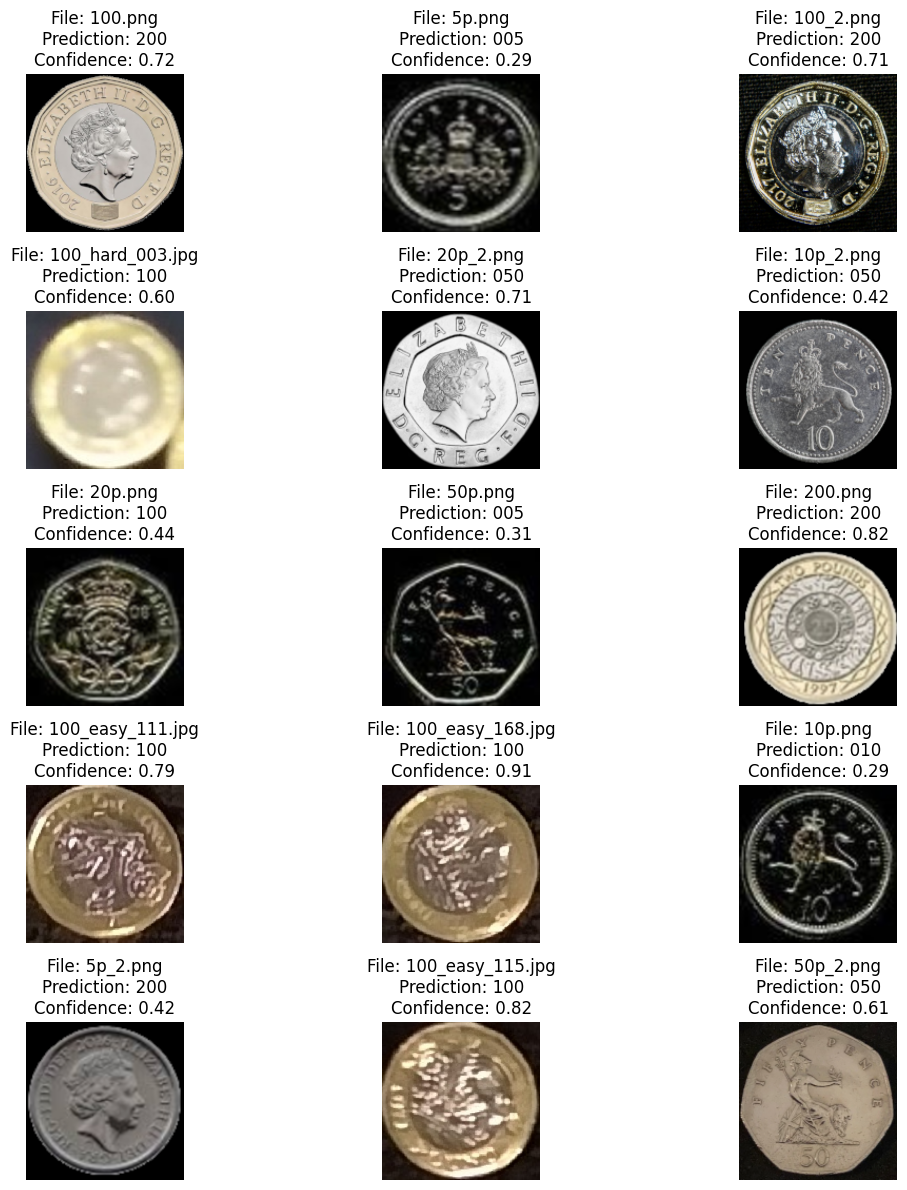


Detailed Prediction Results:
File: 100.png
Predicted class: 200
Confidence: 0.7200
All class probabilities:
  001: 0.0067
  002: 0.0077
  005: 0.0039
  010: 0.0133
  020: 0.0158
  050: 0.1589
  100: 0.0737
  200: 0.7200
--------------------------------------------------
File: 5p.png
Predicted class: 005
Confidence: 0.2949
All class probabilities:
  001: 0.0688
  002: 0.0067
  005: 0.2949
  010: 0.1633
  020: 0.0060
  050: 0.1249
  100: 0.1866
  200: 0.1487
--------------------------------------------------
File: 100_2.png
Predicted class: 200
Confidence: 0.7131
All class probabilities:
  001: 0.0074
  002: 0.0017
  005: 0.0136
  010: 0.0077
  020: 0.0069
  050: 0.0443
  100: 0.2053
  200: 0.7131
--------------------------------------------------
File: 100_hard_003.jpg
Predicted class: 100
Confidence: 0.6025
All class probabilities:
  001: 0.0243
  002: 0.0098
  005: 0.0451
  010: 0.0258
  020: 0.0481
  050: 0.0444
  100: 0.6025
  200: 0.2001
-------------------------------------------

In [13]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

# Path to your test folder
test_folder = "./manual_test/"

# Get list of all image files in the test folder
# Assuming common image extensions like jpg, jpeg, png
image_extensions = ['.jpg', '.jpeg', '.png']
image_files = []

for file in os.listdir(test_folder):
    # Check if the file has an image extension
    if any(file.lower().endswith(ext) for ext in image_extensions):
        image_files.append(os.path.join(test_folder, file))

# Dictionary to map coin indices to their values
# Get class indices from the training generator
coin_labels = UK_train_generator.class_indices
# Invert the dictionary to map indices to labels
coin_labels_inv = {v: k for k, v in coin_labels.items()}

# Process each image and make predictions
results = []

plt.figure(figsize=(12, 12))
num_images = len(image_files)
rows = int(np.ceil(num_images / 3))  # 3 images per row

for i, image_path in enumerate(image_files):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(150, 150))
    x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
    x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)
    x /= 255  # Rescale by 1/255
    
    # Run prediction
    prediction = model.predict(x, verbose=0)  # Set verbose=0 to reduce output
    predicted_class_index = np.argmax(prediction[0])
    predicted_class_name = coin_labels_inv[predicted_class_index]
    confidence = prediction[0][predicted_class_index]
    
    # Extract just the filename for display
    filename = os.path.basename(image_path)
    
    # Store results
    results.append({
        'filename': filename,
        'predicted_class': predicted_class_name,
        'confidence': confidence,
        'prediction_array': prediction[0]
    })
    
    # Display image with prediction
    plt.subplot(rows, 3, i + 1)
    # Load a higher resolution version just for display
    display_img = load_img(image_path, target_size=(300, 300))
    plt.imshow(display_img)
    plt.title(f"File: {filename}\nPrediction: {predicted_class_name}\nConfidence: {confidence:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print detailed results
print("\nDetailed Prediction Results:")
print("=" * 50)
for result in results:
    print(f"File: {result['filename']}")
    print(f"Predicted class: {result['predicted_class']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print("All class probabilities:")
    for class_name, index in coin_labels.items():
        prob = result['prediction_array'][index]
        print(f"  {class_name}: {prob:.4f}")
    print("-" * 50)

# Summarize overall accuracy if ground truth is available in filenames
# Assuming filenames might contain the true class (e.g., "100_coin_01.jpg" for a 100 pence coin)
# This is optional and depends on your naming convention
correct_predictions = 0
total_with_truth = 0

for result in results:
    filename = result['filename']
    # Try to extract ground truth from filename
    # This assumes filenames start with the coin value (e.g., "100_xxx.jpg")
    true_class = None
    for class_name in coin_labels.keys():
        if filename.startswith(class_name):
            true_class = class_name
            break
    
    if true_class:
        total_with_truth += 1
        if true_class == result['predicted_class']:
            correct_predictions += 1

if total_with_truth > 0:
    accuracy = correct_predictions / total_with_truth
    print(f"\nAccuracy on test set (based on filename convention): {accuracy:.2f} ({correct_predictions}/{total_with_truth})")

# Print a summary of the coin distribution in predictions
print("\nPrediction Distribution:")
class_counts = {}
for result in results:
    predicted_class = result['predicted_class']
    if predicted_class in class_counts:
        class_counts[predicted_class] += 1
    else:
        class_counts[predicted_class] = 1

for class_name, count in sorted(class_counts.items()):
    percentage = (count / len(results)) * 100
    print(f"{class_name}: {count} images ({percentage:.1f}%)")